# Objective
Run algorithm one step at a time to experiment with different versions

In [ ]:
# region Set up notebook imports
# %load_ext autoreload
%autoreload 2
# Allow for imports of other scripts
import sys
PATH = "/data/MEAprojects/PropSignal"
if PATH not in sys.path:
    sys.path.append(PATH)
# Reload a module after changes have been made
from importlib import reload
# endregion

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display

from src.prop_signal import *
from src.sorters.prop_signal import PropSignal
from src import plot

In [ ]:
## Set algorithm parameters
THRESH_FREQ = 1
SECONDS_RECORDING = 900
THRESH_NUMBER_SPIKES = None
RATIO = 0.5
THRESH_COOCCURRENCES_NUM = 250
THRESH_COOCCURRENCES_P = 50
P = 50

SMALL_WINDOW = 0.5
BIG_WINDOW = 2
CCG_BEFORE = 1.5
CCG_AFTER = 1.5
CCG_N_BINS = 91

# Load spike times
# For 5RMS thresh crossing inputs, check src/analysis/deprecated/si, to rewrite this, rename "get_inputs_from_maxwell" to just "inputs"
SPIKE_TIMES_PATH = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_crossings_5_neg_only.npy")
##
SPIKE_TIMES = np.load(SPIKE_TIMES_PATH, allow_pickle=True)
##
SPIKE_TIMES = PropSignal.format_thresh_crossings(SPIKE_TIMES)

## Same start
All verions start with the same first step

In [4]:
candidate_cohorts = v1_1.scan_reference_electrode(SPIKE_TIMES, THRESH_FREQ, SECONDS_RECORDING, THRESH_NUMBER_SPIKES, RATIO, SMALL_WINDOW, BIG_WINDOW, CCG_BEFORE, CCG_AFTER, CCG_N_BINS)

## Test v1.1
Graph number of propagations versus thresh_cooccurrence_p

In [5]:
THRESH_P_VALUES = range(0, 100)
##
nums_props = []
for thresh_p in THRESH_P_VALUES:
    electrode_cohorts = v1_1.rescan_candidate_cohorts(candidate_cohorts, THRESH_COOCCURRENCES_NUM, thresh_p, P)
    nums_props.append(len(v1_1.get_propagation(electrode_cohorts)))

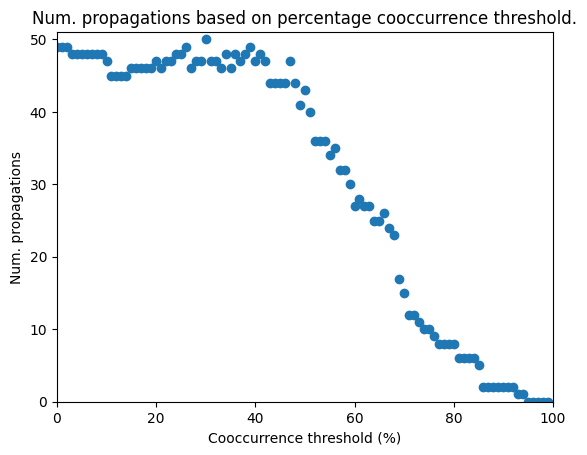

In [6]:
## Create plot
plt.title("Num. propagations based on percentage cooccurrence threshold.")
plt.xlabel("Cooccurrence threshold (%)")
plt.ylabel("Num. propagations")
plt.scatter(THRESH_P_VALUES, nums_props)
plt.xlim(0, max(THRESH_P_VALUES)+1)
plt.ylim(0, max(nums_props)+1)
plt.show()

In [439]:
# Create plot showing mean propagation length based on percentage coocurrence threshold
THRESH_P_VALUES = range(0, 100)
##
means_lens = []
stds_lens = []
for thresh_p in THRESH_P_VALUES:
    electrode_cohorts = v1_1.rescan_candidate_cohorts(candidate_cohorts, THRESH_COOCCURRENCES_NUM, thresh_p, P)
    prop_lens = [len(p) for p in v1_1.get_propagation(electrode_cohorts)]
    if len(prop_lens) > 0:
        means_lens.append(np.mean(prop_lens))
        stds_lens.append(np.std(prop_lens))
    else:
        means_lens.append(0)
        stds_lens.append(0)

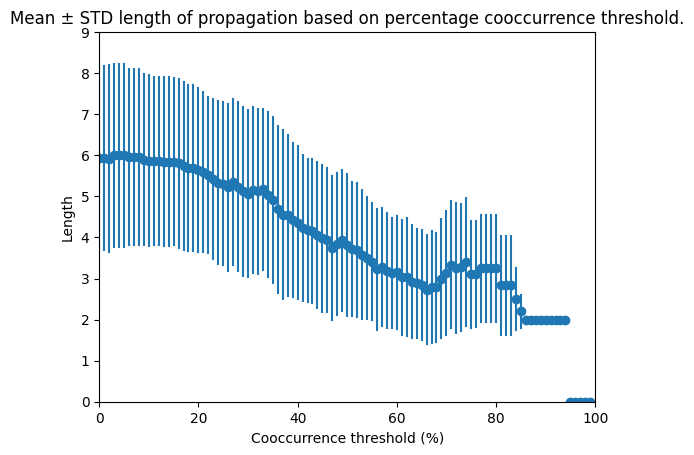

In [454]:
plt.title("Mean ± STD length of propagation based on percentage cooccurrence threshold.")
plt.xlabel("Cooccurrence threshold (%)")
plt.ylabel("Length")
plt.scatter(THRESH_P_VALUES, means_lens)
y_max = max(means_lens)+3
for thresh, mean, std in zip(THRESH_P_VALUES, means_lens, stds_lens):
    plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max)
plt.xlim(0, max(THRESH_P_VALUES)+1)
plt.ylim(0, y_max)
plt.show()

## Investigation
Why is the graph not strictly decreasing?

#### Hypothesis
Because of ```if temps.size > 0 and not np.any(temps[1, :] < 0) and n1 > 1:``` in get_propagations, there may be more propagations with a higher cooccurrence threshold. This line means "if any electrode in a propagation has a negative latency compared to the first electrode, disregard the entire propagation." This prevents double counting the same propagation in a different order. A higher cooccurrence threshold makes it harder for an electrode to join a propagation which decreases the chances of a negative latency electrode joining a propagation. This results in more propagations that are smaller.

In [7]:
for thresh_p in [15, 30]:
    print(f"Cooccurrence threshold: {thresh_p}%")
    electrode_cohorts = v1_1.rescan_candidate_cohorts(candidate_cohorts, THRESH_COOCCURRENCES_NUM, thresh_cooccurrences_p=thresh_p, p=P)
    print(f"Num. elec cohorts: {len(electrode_cohorts)}")
    print(f"Num. elec cohorts with length greater than 1: {len([1 for ec in electrode_cohorts if len(ec) > 1])}")
    print(f"Num. elec cohorts with nonzero latencies: {len([ec for ec in electrode_cohorts if len(ec) > 0 and not np.any(ec[1, :] < 0)])}")
    print(f"Num. propagations: {len(v1_1.get_propagation(electrode_cohorts))}")
    print(f"Mean propagation size: {np.mean([len(ec) for ec in v1_1.get_propagation(electrode_cohorts)]):.2f}")
    print()

Cooccurrence threshold: 15%
Num. elec cohorts: 248
Num. elec cohorts with length greater than 1: 184
Num. elec cohorts with nonzero latencies: 46
Num. propagations: 46
Mean propagation size: 5.85

Cooccurrence threshold: 30%
Num. elec cohorts: 248
Num. elec cohorts with length greater than 1: 168
Num. elec cohorts with nonzero latencies: 50
Num. propagations: 50
Mean propagation size: 5.06



#### Conclusion
The hypothesis is correct.

## Test v1.2
Merging propagations

In [469]:
electrode_cohorts = v1_1.rescan_candidate_cohorts(candidate_cohorts, THRESH_COOCCURRENCES_NUM, thresh_cooccurrences_p=10, p=P)
propagations = v1_2.get_propagations(electrode_cohorts)

In [ ]:
## Compare v1_2 propagations to v1_1 (no additional sorting)
propagations_1 = v1_1.get_propagation(electrode_cohorts)

print(len(propagations) == len(propagations_1))  # Sanity check

for i in range(3, len(propagations), 10):  # Look at some propagations
    print(len(propagations[i]) == len(propagations_1[i]))
    display(propagations[i])
    display(propagations_1[i])
    print()

In [531]:
propagations_merged = v1_2.merge_propagations(propagations, elec_overlap_p=10, seq_order_p=50)

/data/MEAprojects/PropSignal/src/prop_signal/v1_2.py:191: RuntimeWarning: invalid value encountered in long_scalars


In [471]:
# Plot distribution of propagations merged
for prop in propagations_merged:
    if len(prop) > 1:
        for p in prop:
            print(list(p.ID.values))
        print()

[18, 20, 19, 16, 17, 15]
[20, 18, 19, 22, 16, 17, 15]

[53, 54, 51, 50, 52]
[55, 53, 57, 54, 56, 50, 52, 51]

[54, 53, 56, 52, 50]
[57, 54, 56, 53, 52, 55, 59, 50, 51]
[56, 54, 57, 53, 52, 50]

[99, 97, 95, 96, 92, 91, 93, 94]
[101, 99, 97, 100, 95, 96, 92, 98, 94, 93, 91]

[164, 160, 162, 163]
[166, 164, 160, 162, 163]

[194, 197, 195, 196, 198, 199, 201, 203]
[195, 197, 194, 199, 198, 201, 203]

[202, 204, 205, 206, 207, 208, 209, 210]
[204, 205, 202, 206, 208, 210, 209]



In [472]:
print(f"Num. propagations: {len(propagations)}")
print(f"Num. merged propagations: {len(propagations_merged)}")

Num. propagations: 47
Num. merged propagations: 37


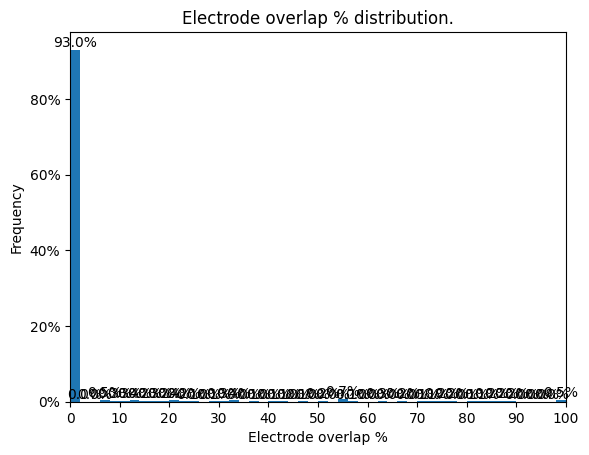

In [566]:
## Graph distribution of electrode overlap scores
scores = []
already_compared = set()
for i_a in range(len(propagations)):
    prop_a = propagations[i_a]
    for i_b in range(len(propagations)):
        if i_a == i_b: continue
        if tuple(sorted((i_a, i_b))) in already_compared: continue

        prop_b = propagations[i_b]

        # Merge based on electrode overlap
        elec_a = prop_a.ID.values
        elec_b = prop_b.ID.values
        _, overlap_a, overlap_b = np.intersect1d(elec_a, elec_b, return_indices=True)
        num_overlap = len(overlap_a)
        overlap_score = num_overlap / (len(elec_a) + len(elec_b) - num_overlap)
        scores.append(overlap_score * 100)

        already_compared.add(tuple(sorted((i_a, i_b))))

# Create plot
plt.title("Electrode overlap % distribution.")
plt.xlabel("Electrode overlap %")
plot.plot_hist_percents(scores, bins=np.arange(0, 101, 2), labels=True)
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 10))
plt.show()

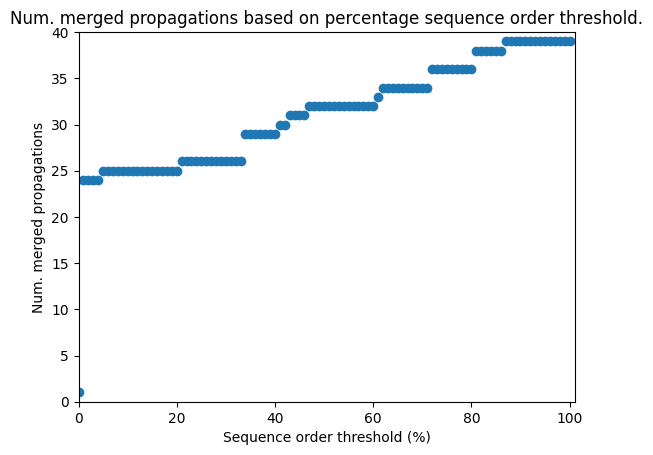

Num. propagations: 47


In [474]:
# Plot number of merged propagations as a function of seq_order_p
ELEC_OVERLAP_P = 10
SEQ_ORDER_P_VALUES = range(0, 101)
##
nums_merges = []
for seq_order_p in SEQ_ORDER_P_VALUES:
    merged_propagations = v1_2.merge_propagations(propagations, ELEC_OVERLAP_P, seq_order_p)
    nums_merges.append(len(merged_propagations))
# Create plot
plt.title("Num. merged propagations based on percentage sequence order threshold.")
plt.xlabel("Sequence order threshold (%)")
plt.ylabel("Num. merged propagations")
plt.scatter(SEQ_ORDER_P_VALUES, nums_merges)
plt.xlim(0, max(SEQ_ORDER_P_VALUES)+1)
plt.ylim(0, max(nums_merges)+1)
plt.show()
print(f"Num. propagations: {len(propagations)}")

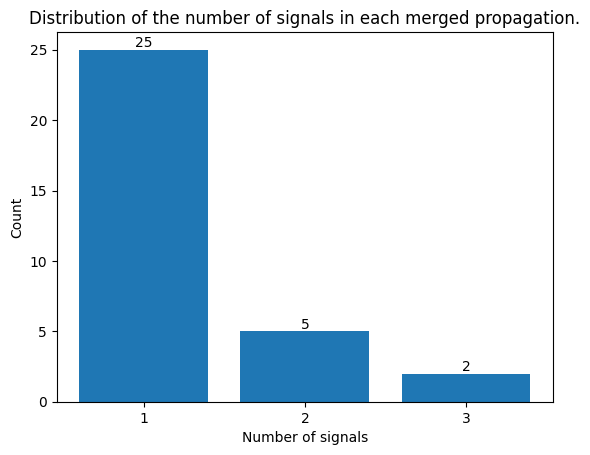

In [475]:
## Plot distribution of number of propagations in each merged propagations
merged_propagations = v1_2.merge_propagations(propagations, elec_overlap_p=10, seq_order_p=50)
plt.title("Distribution of the number of signals in each merged propagation.")
plt.xlabel("Number of signals")
plt.ylabel("Count")
lengths = {}
for p in merged_propagations:
    l = len(p)
    if l not in lengths:
        lengths[l] = 1
    else:
        lengths[l] += 1
plt.bar(lengths.keys(), lengths.values())
plt.xticks(list(lengths.keys()))
for l, c in lengths.items():
    plt.text(l, c, str(c), ha="center", va="bottom")
plt.show()

In [476]:
# Create plot showing mean number of propagations in merge based on sequence order threshold
THRESH_SEQ_ORDER_VALUES = range(0, 100)
##
means_lens = []
stds_lens = []
for thresh_s in THRESH_SEQ_ORDER_VALUES:
    merged_propagations = v1_2.merge_propagations(propagations, ELEC_OVERLAP_P, thresh_s)
    prop_lens = [len(p) for p in merged_propagations]
    if len(prop_lens) > 0:
        means_lens.append(np.mean(prop_lens))
        stds_lens.append(np.std(prop_lens))
    else:
        means_lens.append(0)
        stds_lens.append(0)

/data/MEAprojects/PropSignal/src/prop_signal/v1_2.py:191: RuntimeWarning: invalid value encountered in long_scalars


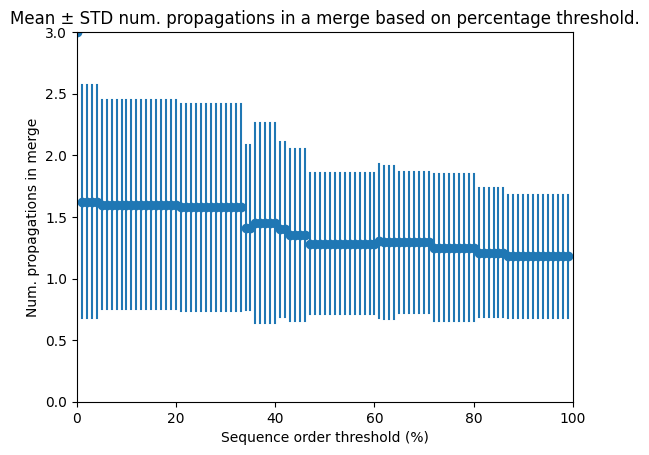

In [480]:
plt.title("Mean ± STD num. propagations in a merge based on percentage threshold.")
plt.xlabel("Sequence order threshold (%)")
plt.ylabel("Num. propagations in merge")
plt.scatter(THRESH_P_VALUES, means_lens)
y_max = max(means_lens)
for thresh, mean, std in zip(THRESH_P_VALUES, means_lens, stds_lens):
    plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max)
plt.xlim(0, max(THRESH_P_VALUES)+1)
plt.ylim(0, y_max)
plt.show()

### Investigation
Investigate propagations with zero latency electrodes.

If prop A has electrodes 1 and 2 and these electrodes have zero latencies. Does this result in a prop B that starts with electrode 2? I.e. a separate propagation?

In [510]:
merged_propagations = v1_2.merge_propagations(propagations, elec_overlap_p=10, seq_order_p=50)
len(merged_propagations)

/data/MEAprojects/PropSignal/src/prop_signal/v1_2.py:191: RuntimeWarning: invalid value encountered in long_scalars


32

In [511]:
id_to_prop = {}
for m, prop_m in enumerate(merged_propagations):
    for prop in prop_m:
        id_to_prop[prop.ID[0]] = (m, prop)

In [512]:
for m, prop_m in enumerate(merged_propagations):
    for p, prop in enumerate(prop_m):
        for i, elec in prop.iterrows():
            if i == 0:
                continue

            if elec.latency == 0 and elec.ID in id_to_prop:
                if m != id_to_prop[elec.ID][0]:
                    print(m, p, elec.ID)
            else:
                break

2 0 11.0
3 0 19.0
3 1 19.0
4 0 18.0
4 0 20.0
10 0 53.0
10 1 53.0
11 0 54.0
11 0 51.0
15 0 77.0
16 0 77.0
16 0 74.0
17 0 74.0
17 0 76.0
23 0 181.0
25 0 177.0


In [484]:
prop_a = merged_propagations[1][0]
prop_a

,ID,latency,small_window_cooccurrences,n1_n2_ratio
0,10,0.000000,19810.0,1.000000
1,12,0.000000,13219.0,0.978171
2,8,0.000000,9573.0,0.980338
3,11,0.000000,9231.0,0.965788
4,7,0.000000,4397.0,0.965313
5,9,0.000000,3931.0,0.941782
6,14,0.033333,6899.0,0.965300


In [485]:
for mp in merged_propagations[2]:
    display(mp)

,ID,latency,small_window_cooccurrences,n1_n2_ratio
0,11,0.000000,19618.0,1.000000
1,12,0.000000,12997.0,0.977880
2,14,0.000000,10820.0,0.988760
3,10,0.000000,9231.0,0.965788
4,13,0.000000,5172.0,0.925555
5,9,0.000000,5017.0,0.959090
6,7,0.000000,2886.0,0.930968
7,8,0.000000,2467.0,0.825084
8,15,0.033333,1986.0,0.802424


In [486]:
prop_b = id_to_prop[10][1]
prop_b

,ID,latency,small_window_cooccurrences,n1_n2_ratio
0,10,0.000000,19810.0,1.000000
1,12,0.000000,13219.0,0.978171
2,8,0.000000,9573.0,0.980338
3,11,0.000000,9231.0,0.965788
4,7,0.000000,4397.0,0.965313
5,9,0.000000,3931.0,0.941782
6,14,0.033333,6899.0,0.965300


In [241]:
v1_2.get_elec_overlap_score(prop_a, prop_b)

0.7

In [237]:
v1_2.get_seq_order_score(prop_a, prop_b)

0.42857142857142855

## Test v1.3
For a propagation signal to detect spikes: within any one of its propagaions, 2 or 3 (low thresh for DL model + strict thresh for alg = good?) electrodes need to be detected.

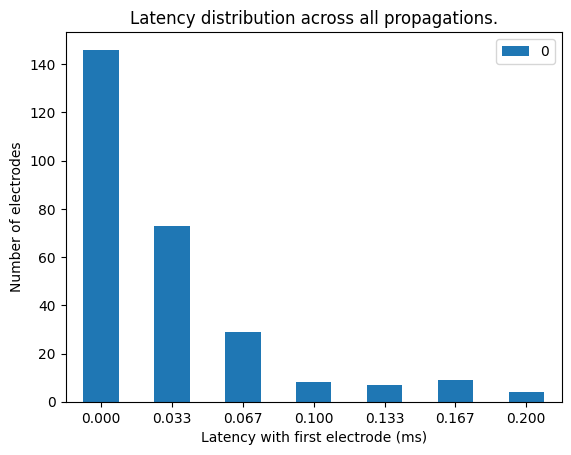

In [541]:
## Plot histogram of latencies
latencies = []
for prop in propagations:
    latencies.extend(prop.latency.values)
latencies, counts = np.unique(latencies, return_counts=True)
from pandas import DataFrame
df = DataFrame(counts, index=[f"{l:.3f}" for l in latencies])
df.plot.bar(rot=0)
plt.title("Latency distribution across all propagations.")
plt.xlabel("Latency with first electrode (ms)")
plt.ylabel("Number of electrodes")
plt.show()

In [536]:
latencies

array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       ])

In [513]:

spike_times = SPIKE_TIMES[:]

# Sort spike times
est_dtype = [('elec', int), ('st', float)]
elec_spike_times = []
for i, elec in enumerate(spike_times):
    elec_spike_times.extend((i, st) for st in elec)
elec_spike_times = np.sort(np.array(elec_spike_times, dtype=est_dtype), order="st")

In [518]:
prop_after = CCG_AFTER
thresh_coactivations = 2

propagating_times = []
from tqdm import tqdm
for prop_m in tqdm(merged_propagations):  # [1:]
    prop_m_times = set()
    for prop in prop_m:
        ref_spike_times = spike_times[prop.ID[0]]

        tar_spike_times_all = []
        for elec in prop.ID[1:]:
            tar_spike_times = spike_times[elec]
            for ref in ref_spike_times:
                if np.any((tar_spike_times > ref) & (tar_spike_times <= ref + prop_after)):
                    tar_spike_times_all.append(ref)

        prop_spike_times, st_counts = np.unique(tar_spike_times_all, return_counts=True)
        prop_m_times.update(prop_spike_times[st_counts >= thresh_coactivations-1])  # Just being in the list counts as 2 coactivations
    propagating_times.append(np.sort(list(prop_m_times)))


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


In [519]:
HIST_KWARGS = {"bins":15}

Total: 247864
Mean: 7745.75
STD: 6346.69


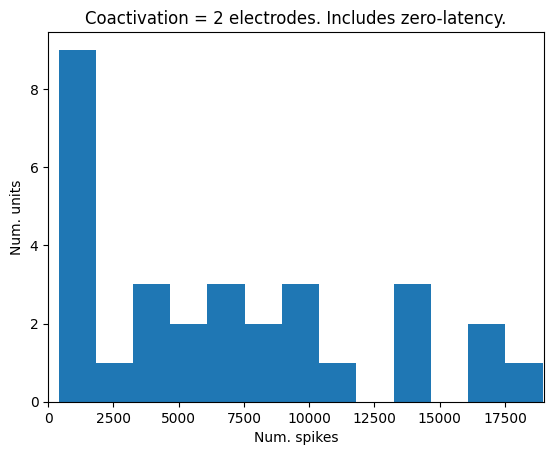

In [527]:
# Plot distribution of the number of spike times on each unit
# propagating_times_coactivation_2_zero_latency = propagating_times[:]
nums_spikes = [len(st) for st in propagating_times_coactivation_2_zero_latency]
plt.hist(nums_spikes, **HIST_KWARGS)
plt.xlabel("Num. spikes")
plt.ylabel("Num. units")
plt.xlim(0, 19000)
print(f"Total: {np.sum(nums_spikes)}")
print(f"Mean: {np.mean(nums_spikes):.2f}")
print(f"STD: {np.std(nums_spikes):.2f}")
plt.title("Coactivation = 2 electrodes. Includes zero-latency.")
plt.show()

Total: 175265
Mean: 5477.03
STD: 4961.17


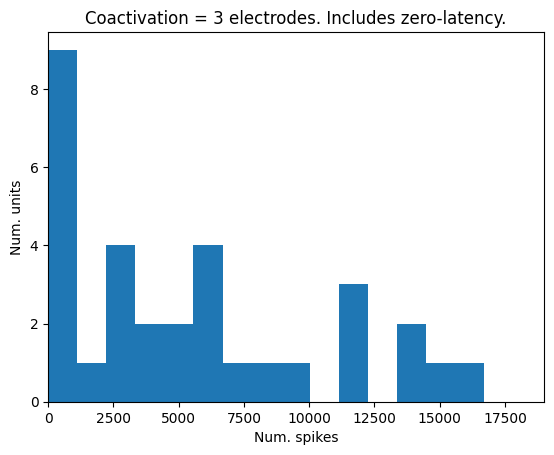

In [528]:
# Plot distribution of the number of spike times on each unit
# propagating_times_coactivation_3_zero_latency = propagating_times[:]
nums_spikes = [len(st) for st in propagating_times_coactivation_3_zero_latency]
plt.hist(nums_spikes, **HIST_KWARGS)
plt.xlabel("Num. spikes")
plt.ylabel("Num. units")
plt.xlim(0, 19000)
print(f"Total: {np.sum(nums_spikes)}")
print(f"Mean: {np.mean(nums_spikes):.2f}")
print(f"STD: {np.std(nums_spikes):.2f}")
plt.title("Coactivation = 3 electrodes. Includes zero-latency.")
plt.show()

Total: 118169
Mean: 3692.78
STD: 3540.88


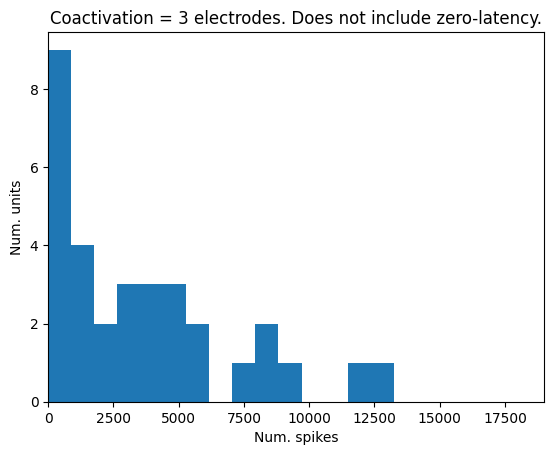

In [529]:
# Plot distribution of the number of spike times on each unit
# propagating_times_coactivation_3 = propagating_times[:]
nums_spikes = [len(st) for st in propagating_times_coactivation_3]
plt.hist(nums_spikes, **HIST_KWARGS)
plt.xlabel("Num. spikes")
plt.ylabel("Num. units")
plt.xlim(0, 19000)
print(f"Total: {np.sum(nums_spikes)}")
print(f"Mean: {np.mean(nums_spikes):.2f}")
print(f"STD: {np.std(nums_spikes):.2f}")
plt.title("Coactivation = 3 electrodes. Does not include zero-latency.")
plt.show()

Total: 194114
Mean: 6066.06
STD: 5036.74


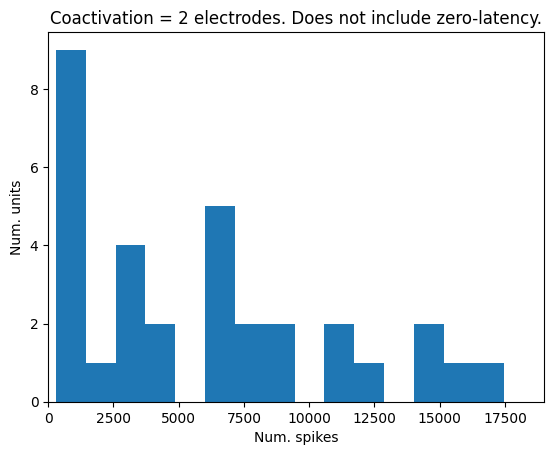

In [530]:
# Plot distribution of the number of spike times on each unit
# propagating_times_coactivation_2 = propagating_times[:]
nums_spikes = [len(st) for st in propagating_times_coactivation_2]
plt.hist(nums_spikes, **HIST_KWARGS)
plt.xlabel("Num. spikes")
plt.ylabel("Num. units")
plt.xlim(0, 19000)
print(f"Total: {np.sum(nums_spikes)}")
print(f"Mean: {np.mean(nums_spikes):.2f}")
print(f"STD: {np.std(nums_spikes):.2f}")
plt.title("Coactivation = 2 electrodes. Does not include zero-latency.")
plt.show()

## Investigation
Look at v1 prop signal results

In [381]:
from src.sorters import PropSignal, Kilosort
from src.comparison import Comparison

In [386]:
prop_signal_1 = PropSignal("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal")

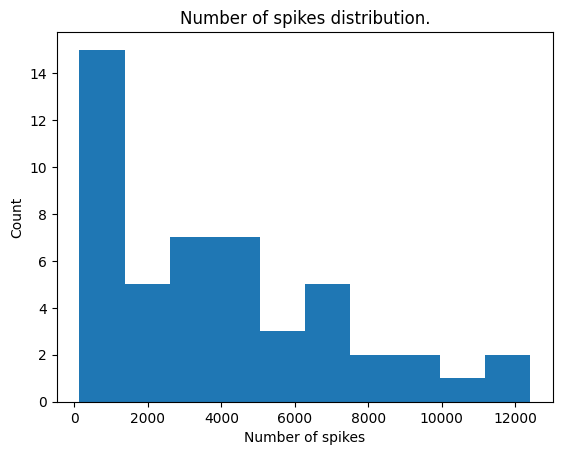

In [321]:
prop_signal_1.plot_nums_spikes()

In [353]:
def get_propagation_time_zero(list_of_propagation, spike_times, prop_after):
    """
    This function generates a sequence of eAPs for each
    propagation using different number of anchor points

    Inputs:
        list_of_propagation: list
            Output of get_propagation with P elements.
            Each element is a pandas.DataFrame of electrode cohorts for each propagation
            in a recording. Each DataFrame provides a list of candidate
            electrodes along with the latency between each electrode
            with the reference electrode, the number of co-occurrences,
            and the n1/n2 ratio.
        spike_times: list
            Contains N elements, each representing 1 electrode.
            Each element contains a np.array with shape (m,) representing
            the spike times for each electrode.
        ccg_after: int or float
            Maximum time after reference spike to classify the target spike as
            a propagation of the reference spike.
            For example, if reference spike is at time 0 and prop_after=1.5,
            any target spike within the interval (0, 1.5) will be classified as a
            propagation of reference spike

    Output:
        propagating_times: list
            Contains P elements where each element contains a 1d np.array with shape (Q,)
            of spike times in the propagation with different number of anchor points chosen
            for each propagation in list_of_propagation. The pth element in propagating_times
            contains the spike times for the pth element in list_of_propagation.

            The qth element in the inner array with shape (Q,) is an array containing the
            propagating spike times isolated with q+1 anchor points. I.e. the 0th element
            contains the propagating spike times isolated with 1 anchor point (an empty array),
            the 1st element contains propagating spike times isolated with 2 anchor points,
            the 2nd element contains propagating spike times isolated with 3 anchor points,
            etc., until all constituent electrodes are used as anchor points.
    """

    n = len(list_of_propagation)
    propagating_times = []
    for i in tqdm(range(n)):
        time_signal = [np.array([])]
        time = []
        current_signal = list_of_propagation[i]

        ind0 = 0
        # index = np.flatnonzero(current_signal.loc[:, "latency"] >= 0)  # 0.001
        # current_signal = current_signal.loc[index, :].copy()
        size_of_signal, _ = current_signal.shape

        current_signal.loc[ind0, "small_window_cooccurrences"] = -888
        ID0 = current_signal.loc[ind0, "ID"]
        reference_spike_times = spike_times[ID0]

        for n_ele in range(1, size_of_signal):  # ele = electrode
            ind1 = current_signal.loc[:, "small_window_cooccurrences"].idxmax()
            current_signal.loc[ind1, "small_window_cooccurrences"] = -888
            ID1 = current_signal.loc[ind1, "ID"]
            target_spike_times = spike_times[ID1]

            ind_all = []
            for j in range(reference_spike_times.size):
                ref = reference_spike_times[j]
                index = np.flatnonzero((target_spike_times >= ref) & (target_spike_times <= ref+prop_after))
                if index.size > 0:
                    ind_all.append(j)

            time.extend(reference_spike_times[ind_all])
            time_signal.append(np.sort(np.unique(time)))
        propagating_times.append(np.asarray(time_signal, dtype=object))

    return propagating_times
propagating_times_1 = get_propagation_time_zero(propagations_1, SPIKE_TIMES, CCG_AFTER)

100%|██████████| 49/49 [00:29<00:00,  1.64it/s]


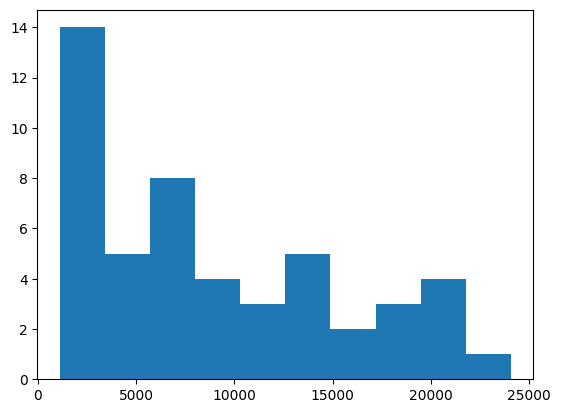

438644


In [382]:
# Plot distribution of the number of spike times on each unit
nums_spikes = [len(st[-1]) for st in propagating_times_1]
plt.hist(nums_spikes)
plt.show()
print(sum(nums_spikes))

In [383]:
prop_signal_1.props_times = propagating_times_1

In [384]:
# Load kilosort
kilosort = Kilosort("000034", "initial")

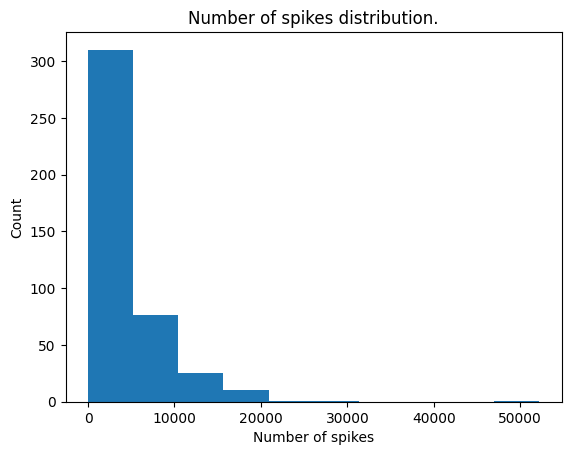

TypeError: unsupported operand type(s) for /: 'generator' and 'int'

In [376]:
kilosort.plot_nums_spikes()

In [377]:
print(np.mean([len(st) for st in kilosort.get_spike_times()]))

3878.7146226415093


Getting match counts and agreement scores


100%|██████████| 49/49 [00:16<00:00,  3.01it/s]

Matches/Num Kilosort: 10/424


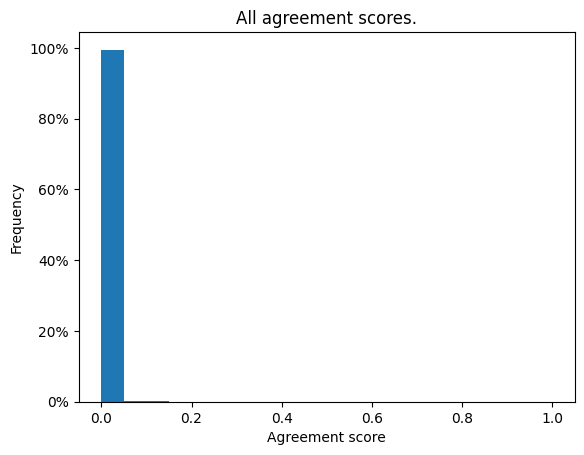

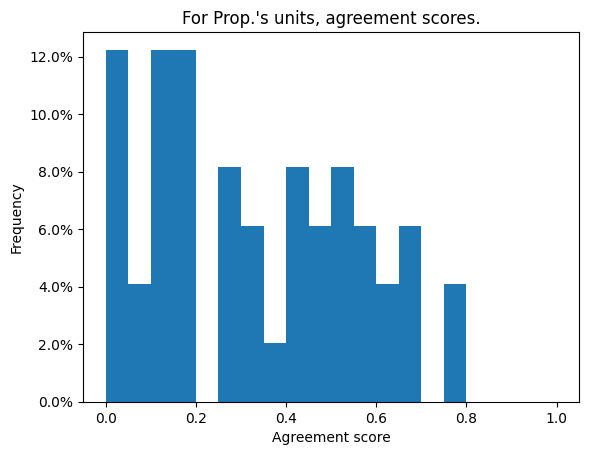

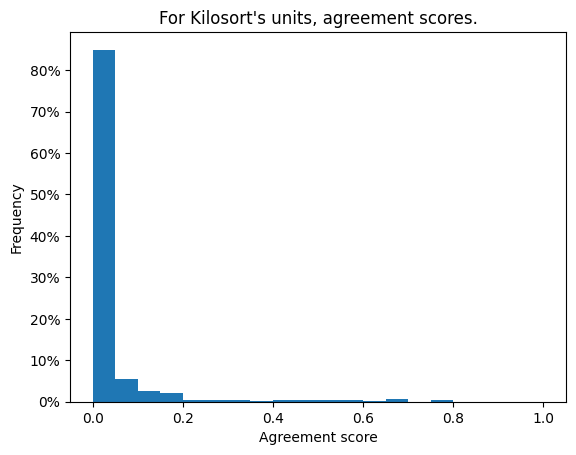

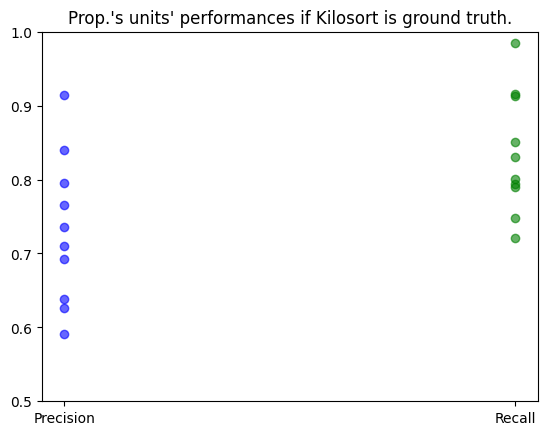

In [387]:
comp_1 = Comparison(prop_signal_1, kilosort)

In [ ]:
# 7 if using zero-latency spikes

## Test multiple units having same starting electrode
Determine if this is a problem that needs to be solved or is so rare that it can be ignored

In [416]:
def get_latency_dist(elec_a, elec_b):
    # Latency of all of elec_a spike times compared to closest spike time in elec_b
    a_b = []
    for st in elec_a:
        idx_b = np.searchsorted(elec_b, st)
        if idx_b == 0:
            closest = elec_b[0]
        elif idx_b == len(elec_b):
            closest = elec_b[-1]
        else:
            left_diff = st - elec_b[idx_b-1]
            right_diff = elec_b[idx_b] - st
            if left_diff < right_diff:
                closest = elec_b[idx_b-1]
            else:
                closest = elec_b[idx_b]
        a_b.append(closest-st)
    return np.array(a_b)

In [423]:
# from scipy.stats import ks_2samp
# latency_matrix = np.zeros((len(SPIKE_TIMES), len(SPIKE_TIMES)), dtype=float)
# for a in range(len(SPIKE_TIMES)):
#     for b in range(len(SPIKE_TIMES)):
#         a_b = get_latency_dist(SPIKE_TIMES[a], SPIKE_TIMES[b])
#         b_a = -get_latency_dist(SPIKE_TIMES[b], SPIKE_TIMES[a])
#         latency_matrix[a, b] = ks_2samp(a_b, b_a)[1]

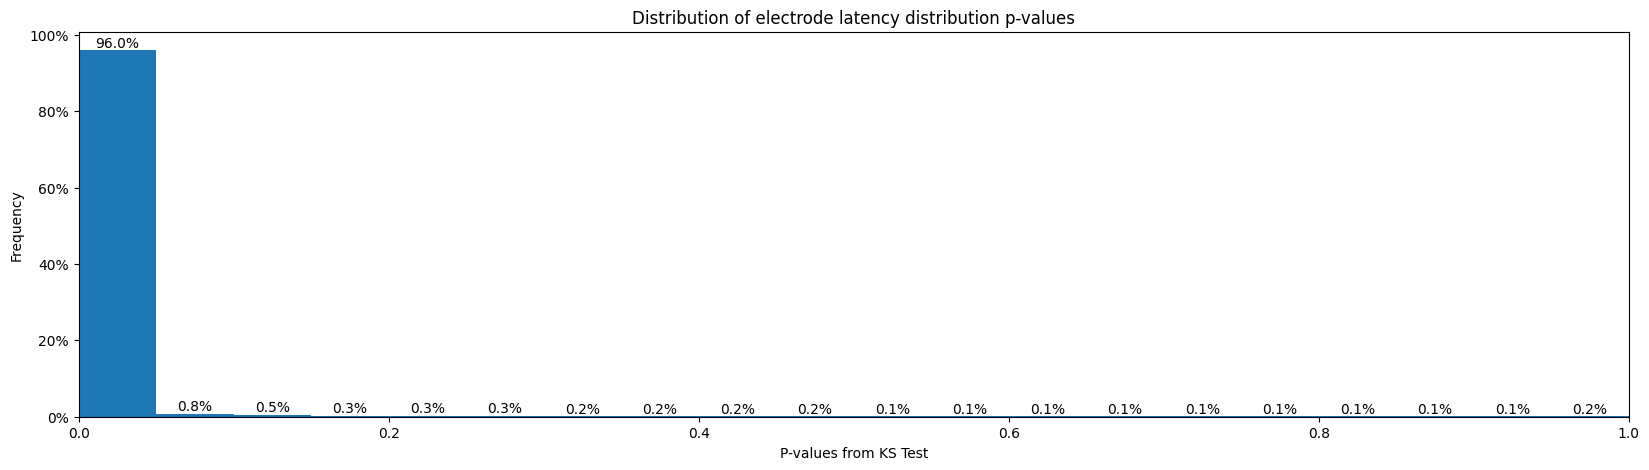

In [558]:
unique_p_ind = np.triu_indices_from(latency_matrix, k=1)
from src.plot import plot_hist_percents
plt.figure(figsize=(20, 5))
plt.title("Distribution of electrode latency distribution p-values")
plot_hist_percents(latency_matrix[unique_p_ind], labels=True, bins=20)
plt.xlabel("P-values from KS Test")
plt.xlim(0, 1)
plt.show()

In [548]:
from scipy.io import savemat
savemat('/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/p_values.mat', {"p_values": latency_matrix})